# Modeling

## Preparation

In [27]:
# Loading Libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import causalnex
from causalnex.structure.notears import from_pandas
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from causalnex.discretiser import Discretiser
from causalnex.structure import DAGRegressor
from causalnex.inference import InferenceEngine
from causalnex.network import BayesianNetwork
from causalnex.network.sklearn import BayesianNetworkClassifier
import os
import sys
from IPython.display import Image
import copy
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading Dataset

raw_df = pd.read_csv("../data/data.csv")
raw_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


### Feature Extraction

In [28]:
# Separating features and target
 
features_df = raw_df.drop('diagnosis',axis=1).iloc[:,:-1]
target_df = raw_df['diagnosis']

In [44]:
# random forest checker
def forest_test(features_r, target_r):
    features = StandardScaler().fit_transform(features_r)
    target = LabelEncoder().fit_transform(target_r)

    X_Train, X_Test, Y_Train, Y_Test = train_test_split(features, target, 
                                                        test_size = 0.30, 
                                                        random_state = 11)
    forest = RandomForestClassifier(n_estimators=700)
    _ = forest.fit(X_Train, Y_Train)
    print(f"accuracy score: {forest.score(X_Test, Y_Test)}")

In [45]:
forest_test(features_df, target_df)

accuracy score: 0.9649122807017544


In [33]:
def select_features_RFE(features_r, target_r, num):
    features = StandardScaler().fit_transform(features_r)
    target = LabelEncoder().fit_transform(target_r)
    # Init the transformer
    rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=num)

    # Fit to the training data
    _ = rfe.fit(features, target)

    # extract features
    new_features = features_r.loc[:, rfe.support_]

    return new_features
        

In [46]:
selected_feat = select_features_RFE(features_df, target_df, 7)
selected_feat.head()

,texture_mean,concave points_mean,radius_worst,texture_worst,perimeter_worst,area_worst,concave points_worst
0,10.38,0.14710,25.38,17.33,184.60,2019.0,0.2654
1,17.77,0.07017,24.99,23.41,158.80,1956.0,0.1860
2,21.25,0.12790,23.57,25.53,152.50,1709.0,0.2430
3,20.38,0.10520,14.91,26.50,98.87,567.7,0.2575
4,14.34,0.10430,22.54,16.67,152.20,1575.0,0.1625


In [47]:
forest_test(selected_feat, target_df)

accuracy score: 0.9532163742690059


### Observation
- As can be seen from the random forest regression test, the accuracy has decreased only by 1%

### Scaling and Normalization

In [57]:
def normalize(df):
  normald = Normalizer()
  normal = pd.DataFrame(normald.fit_transform(df))
  return normal

def scale(df):
  scaler = MinMaxScaler()
  scaled = pd.DataFrame(scaler.fit_transform(df))
  return scaled

def scale_and_normalize(df):
  columns = df.columns.to_list()
  normScaled = normalize(scale(df))
  normScaled.columns = columns
  return normScaled


In [49]:
# features before scaling
selected_feat.head()

,texture_mean,concave points_mean,radius_worst,texture_worst,perimeter_worst,area_worst,concave points_worst
0,10.38,0.14710,25.38,17.33,184.60,2019.0,0.2654
1,17.77,0.07017,24.99,23.41,158.80,1956.0,0.1860
2,21.25,0.12790,23.57,25.53,152.50,1709.0,0.2430
3,20.38,0.10520,14.91,26.50,98.87,567.7,0.2575
4,14.34,0.10430,22.54,16.67,152.20,1575.0,0.1625


In [58]:
# scaling and normalizing
scaled = scale_and_normalize(selected_feat)
scaled.head()

,texture_mean,concave points_mean,radius_worst,texture_worst,perimeter_worst,area_worst,concave points_worst
0,0.014559,0.469784,0.398885,0.090938,0.429429,0.289600,0.586032
1,0.219236,0.280512,0.488141,0.244168,0.434184,0.350050,0.514099
2,0.269839,0.439535,0.384704,0.248968,0.351554,0.258948,0.577383
3,0.298195,0.432091,0.205202,0.318928,0.199447,0.077688,0.731259
4,0.139256,0.461043,0.462248,0.110224,0.450867,0.303789,0.496645


## Causal Graph Discovery

In [63]:
# rejoin target and features
pure_df = selected_feat.copy()
pure_df["target"] = LabelEncoder().fit_transform(target_df)

# 1 means Malignunt and 0 means Benign 
pure_df.head()

,texture_mean,concave points_mean,radius_worst,texture_worst,perimeter_worst,area_worst,concave points_worst,target
0,10.38,0.14710,25.38,17.33,184.60,2019.0,0.2654,1
1,17.77,0.07017,24.99,23.41,158.80,1956.0,0.1860,1
2,21.25,0.12790,23.57,25.53,152.50,1709.0,0.2430,1
3,20.38,0.10520,14.91,26.50,98.87,567.7,0.2575,1
4,14.34,0.10430,22.54,16.67,152.20,1575.0,0.1625,1


In [65]:
factor = len(pure_df)/100
pure_20 = pure_df.sample(int(20*factor), random_state=11)
print(f"size of pure_20 : {len(pure_20)}")
pure_40 = pure_df.sample(int(40*factor), random_state=11)
print(f"size of pure_40 : {len(pure_40)}")
pure_60 = pure_df.sample(int(60*factor), random_state=11)
print(f"size of pure_60 : {len(pure_60)}")
pure_80 = pure_df.sample(int(80*factor), random_state=11)
print(f"size of pure_80 : {len(pure_80)}")
print(f"size of pure_100 : {len(pure_df)}")

size of pure_20 : 113
size of pure_40 : 227
size of pure_60 : 341
size of pure_80 : 455
size of pure_100 : 569


In [69]:
def apply_treshold(sm, th):
  sm_copy = copy.deepcopy(sm)
  sm_copy.remove_edges_below_threshold(th)

  return sm_copy
  
def plot_graph(sm, th):
  tmp = apply_treshold(sm, th)
  viz = plot_structure(
      tmp,
      graph_attributes={"scale": "2.5", 'size': 2},
      all_node_attributes=NODE_STYLE.WEAK,
      all_edge_attributes=EDGE_STYLE.WEAK)
  return Image(viz.draw(format='png'))

def jacc_index(sm1, sm2, th1, th2, formatted=True):
  sm1_copy = copy.deepcopy(sm1)
  sm2_copy = copy.deepcopy(sm2)
  sm1_copy.remove_edges_below_threshold(th1)
  sm2_copy.remove_edges_below_threshold(th2)
  a = sm1_copy.edges
  b = sm2_copy.edges
  n = set(a).intersection(b)
  sim = round(len(n) / (len(a) + len(b) - len(n)), 2)
  if(formatted):
    return f"The similarity index: {sim}"
  else:
    return sim 

In [66]:
# generate the ground truth structure
ground_truth = from_pandas(pure_df, tabu_parent_nodes=["target"])

In [67]:
# generate structures from fractional datasets

sm20 = from_pandas(pure_20, tabu_parent_nodes=["target"])
sm40 = from_pandas(pure_40, tabu_parent_nodes=["target"])
sm60 = from_pandas(pure_60, tabu_parent_nodes=["target"])
sm80 = from_pandas(pure_80, tabu_parent_nodes=["target"])

### Check Stability of Graph

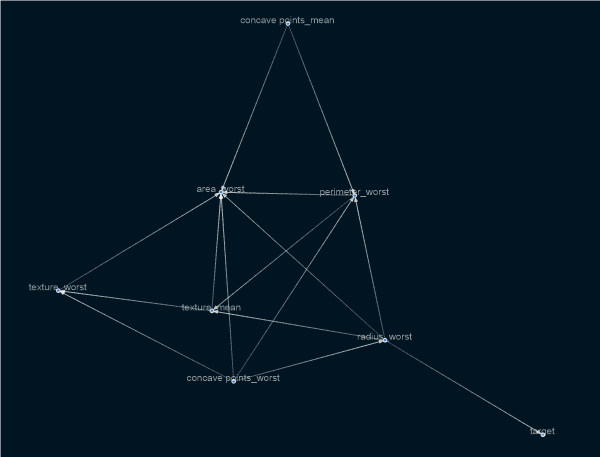

In [74]:
plot_graph(ground_truth, 0.1)

The similarity index: 0.44


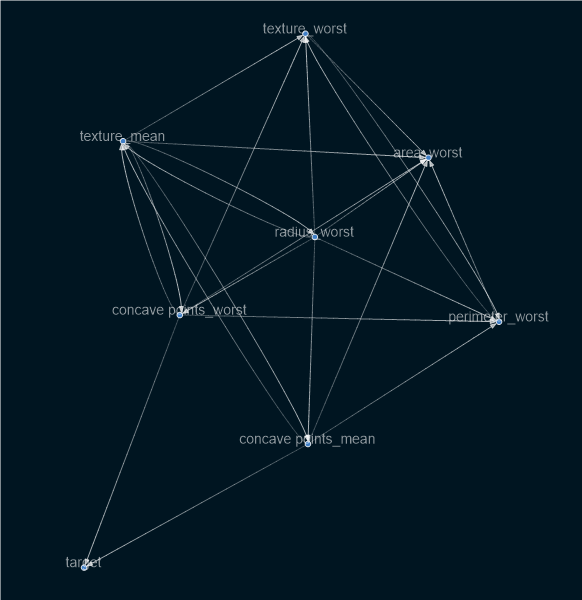

In [76]:
print(jacc_index(ground_truth,sm20, 0.1, 0.3))
plot_graph(sm20, 0.3)

The similarity index: 0.59


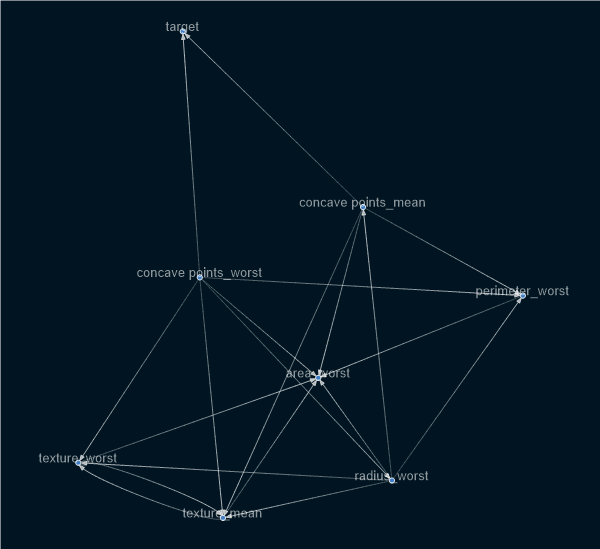

In [77]:
print(jacc_index(ground_truth,sm40, 0.1, 0.3))
plot_graph(sm40, 0.3)

The similarity index: 0.76


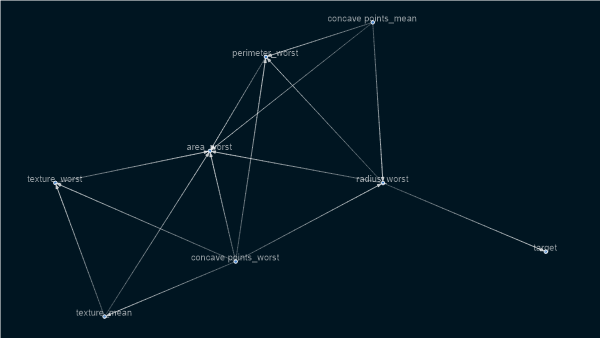

In [78]:
print(jacc_index(ground_truth,sm60, 0.1, 0.3))
plot_graph(sm60, 0.3)

The similarity index: 0.88


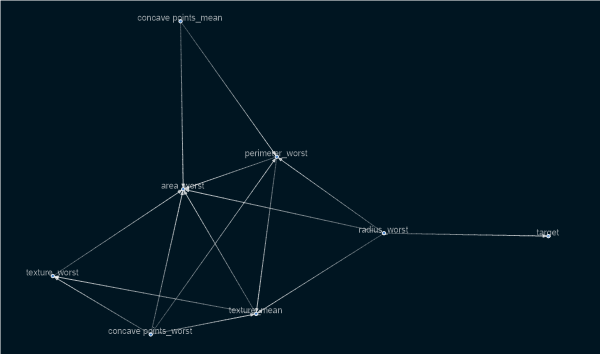

In [80]:
print(jacc_index(ground_truth,sm80, 0.1, 0.1))
plot_graph(sm80, 0.1)

## Bayesian Network Modeling

In [83]:
# Extract Causal Blanket

sm_n = apply_treshold(ground_truth, 0.1)
blanket = sm_n.get_markov_blanket('target')
print(blanket.edges)

[('radius_worst', 'target')]


## Logistic Regression Modeling